In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, balanced_accuracy_score
from sklearn.decomposition import TruncatedSVD

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.pipeline import make_pipeline

In [32]:
#Load in dataframe to model
df = pd.read_csv('../data/cleaning_data_phase2.csv.zip')
df.head()

,_michd,_sex,genhlth,physhlth,menthlth,addepev3,checkup1,_totinda,_rfhype6,cholmed3,...,_metstat,_imprace,_age80,_educag,ftjuda2_,frutda2_,grenda1_,frnchda_,potada1_,vegeda2_
0,No,Female,Poor,20.0,10.0,No,Within past 2 years (1 year but < 2 years ago),No physical activity or exercise in last 30 days,No,Yes,...,yes,white,70.0,highschool,5.397605e-79,100.0,5.700000e+01,4.300000e+01,14.0,100.0
1,Yes,Female,Good,0.0,0.0,No,Within past year (anytime < 12 months ago),Had physical activity or exercise,Yes,Yes,...,yes,black,67.0,graduated college,5.397605e-79,100.0,1.400000e+01,5.397605e-79,14.0,100.0
2,Yes,Female,Very good,0.0,0.0,No,Within past year (anytime < 12 months ago),No physical activity or exercise in last 30 days,Yes,No,...,yes,black,72.0,highschool,5.397605e-79,100.0,5.397605e-79,1.400000e+01,14.0,43.0
3,No,Female,Very good,0.0,10.0,No,Within past year (anytime < 12 months ago),Had physical activity or exercise,Yes,No,...,yes,white,62.0,highschool,7.100000e+01,43.0,1.000000e+01,5.700000e+01,27.0,71.0
4,Yes,Male,Poor,30.0,0.0,No,Within past year (anytime < 12 months ago),Had physical activity or exercise,No,Yes,...,no,other race,76.0,no highschool,5.397605e-79,100.0,1.000000e+02,2.900000e+01,29.0,100.0


# Missing data:

There are missing values in the dataset, to deal with this we will try different methods of imputation. When imputing, we will treat numerical and categorical features differently.

In [33]:
df.isnull().sum()

_michd          0
_sex            0
genhlth         0
physhlth     8491
menthlth     7084
addepev3        0
checkup1        0
_totinda        0
_rfhype6        0
cholmed3        0
_rfchol3        0
cvdstrk3        0
_asthms1        0
chcscncr        0
chcocncr        0
chccopd3        0
chckdny2        0
diabete4        0
_drdxar3        0
marital         0
children     3684
_incomg1        0
employ1         0
htm4         9849
wtkg3       25486
_bmi5       30786
decide          0
diffwalk        0
diffdres        0
_state          0
_smoker3        0
usenow3         0
ecignow1        0
_drnkwk1    15125
_metstat        0
_imprace        0
_age80          0
_educag         0
ftjuda2_    24072
frutda2_    23649
grenda1_    23943
frnchda_    24471
potada1_    28095
vegeda2_    28150
dtype: int64

In [79]:
#For imputation later
#List of categorical features
categorical_features = [df.columns[i] for i in range(len(df.columns)) if df.dtypes[i] == 'object']
categorical_features.remove('_michd') #No need to have the target variable in there

#List of numerical features
numerical_features = [df.columns[i] for i in range(len(df.columns)) if df.dtypes[i] == 'float64']

# Splitting the data into a train and test group

In [280]:
#Features to be used in model
X = df.drop(columns = '_michd')

#Target variable
y = df['_michd'].map({'Yes':1, 'No':0})

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

# Metric Function

In [162]:
#Function to display metrics of interest
def my_metrics(estimator, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
    
    train_preds = estimator.predict(X_train)
    preds = estimator.predict(X_test)
    
    train_acc = accuracy_score(y_train, train_preds)
    train_recall = recall_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    balanced = balanced_accuracy_score(y_test, preds)
    
    print(f'Train Accuracy: {train_acc}')
    print(f'Test Recall: {train_recall}')
    print(f'Test Accuracy: {test_acc}')
    print(f'Balanced Accuracy: {balanced}')
    print(f'Recall: {recall}')
    print()
    print(f'Test Confusion Matrix:')
    ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test)

# First model:

**Strategy:**
- Impute numerical values with median
- All else is default to multnomial Naive Bayes

In [146]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('median_imputer', SimpleImputer(strategy = 'median'))
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#Estimator pipeline with our preprocessing in there
multi_nb_classifier = Pipeline([
    ('pre', preprocess),
    ('mnb', MultinomialNB())
])

multi_nb_classifier.fit(X_train, y_train);

Train Accuracy: 0.331156737422117
Test Accuracy: 0.3310109236885784
Balanced Accuracy: 0.5575509776483296
Recall: 0.8286351891003054

Test Confusion Matrix:


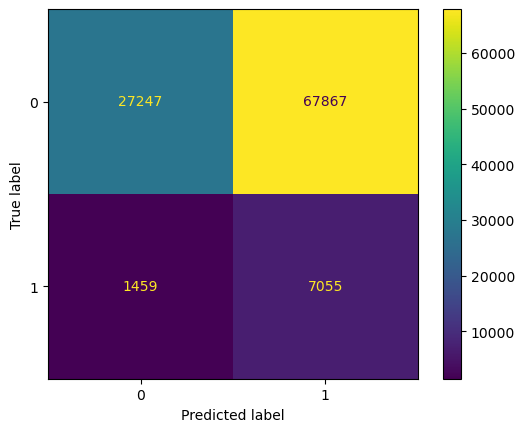

In [147]:
#Metrics
my_metrics(multi_nb_classifier)

Although this has a very low accuracy score, recall is quite high. Out of every 10 people with hear disease, this model is able to pick up on 80% of them. The issue is that it also predict many many healthy people to be sick as well.

# Second model:

**Strategy:**
- Build off of first model
- Grid search over different imputing strategies and MultiNB hyper params

In [165]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer())
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#Estimator pipeline with our preprocessing in there
multi_nb_classifier = Pipeline([
    ('pre', preprocess),
    ('mnb', MultinomialNB())
])

#Parameter for the grid search
grid_params = {
    'pre__numerical__imputer__strategy': ['mean', 'median', 'most_frequent'], #Different imputation strategies
    'mnb__alpha': [.001,.01,.1,1,10] #Different alpha values
}

#Grid Search with maximizing balanced accuracy
grid_mnb_class = GridSearchCV(multi_nb_classifier, grid_params, scoring = 'recall') #Maximize for recall

#Fit model to training data
grid_mnb_class.fit(X_train, y_train);

/Users/lucas_ogilvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucas_ogilvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucas_ogilvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucas_ogilvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/lucas_ogilvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/lucas_ogilvie/opt/anaconda3/lib/python3.9/site-

Train Accuracy: 0.35225792339883494
Test Recall: 0.8098817633701355
Test Accuracy: 0.3531960474003165
Balanced Accuracy: 0.5622041515514025
Recall: 0.8123091378905333

Test Confusion Matrix:


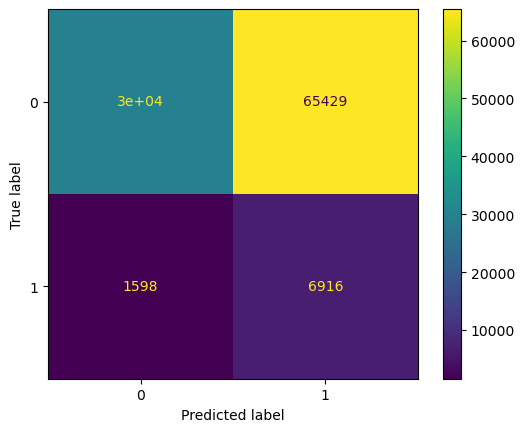

In [166]:
#Metrics
my_metrics(grid_mnb_class)

In [167]:
grid_mnb_class.best_params_

{'mnb__alpha': 0.001, 'pre__numerical__imputer__strategy': 'mean'}

The secon model had slightly higher accuracy but slightly worse recall. The best imputer strategy was mean imputation.

# Third model

**Strategy:**
- Build off of second model
- Use best hyperparams found from the second model so we don't need to grid search and save time
- Impute for categorical variables: 
    - Replace values like 'missing', 'not sure', 'refused' with one constant value of 'missing'

In [282]:
#Replacing all values of the 'don't know', 'refused' and 'missing' sort with None values to represent them as missing for our imputer
X_train_cleaned = X_train.replace(["Don't know/Not sure", 'Refused', 'Not asked or Missing', 'Don’t know/Refused/Missing', 
 'Don’t know/Not Sure/Refused/Missing', 'Don’t know/Not Sure Or Refused/Missing',
 'not sure', 'refused', 'unknown', 'missing', 'Don’t know/Not Sure', 'not_sure'], 'missing')

X_test_cleaned = X_test.replace(["Don't know/Not sure", 'Refused', 'Not asked or Missing', 'Don’t know/Refused/Missing', 
 'Don’t know/Not Sure/Refused/Missing', 'Don’t know/Not Sure Or Refused/Missing',
 'not sure', 'refused', 'unknown', 'missing', 'Don’t know/Not Sure', 'not_sure'], 'missing')


In [209]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')) #Imputing median for missing values
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#Estimator pipeline with our preprocessing in there
multi_nb_classifier = Pipeline([
    ('pre', preprocess),
    ('mnb', MultinomialNB(alpha = .00000001))
])

#Fit model
multi_nb_classifier.fit(X_train_cleaned, y_train);

Train Accuracy: 0.3296384813579385
Test Recall: 0.8273040482342808
Test Accuracy: 0.3293607905199367
Balanced Accuracy: 0.556652056353883
Recall: 0.8286351891003054

Test Confusion Matrix:


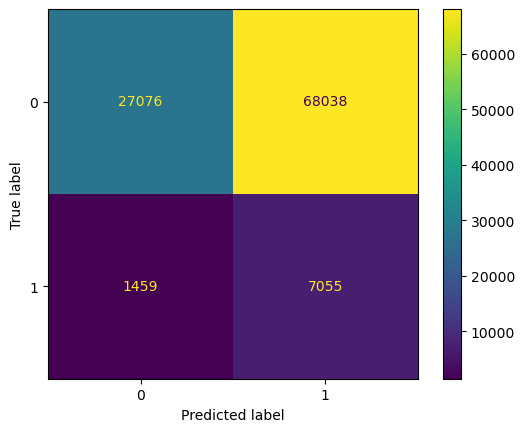

In [210]:
#Metrics
my_metrics(multi_nb_classifier, X_train_cleaned, X_test_cleaned)

Better Recall but worse accuaracy. Not much different than past two models.

# Fourth Model:

**Strategy:**
- Let's try and add some Min Max scaler to numerical pipeline

Train Accuracy: 0.8584161887269487
Test Recall: 0.4870801033591731
Test Accuracy: 0.8571235573397151
Balanced Accuracy: 0.6869527594173319
Recall: 0.48332158797275077

Test Confusion Matrix:


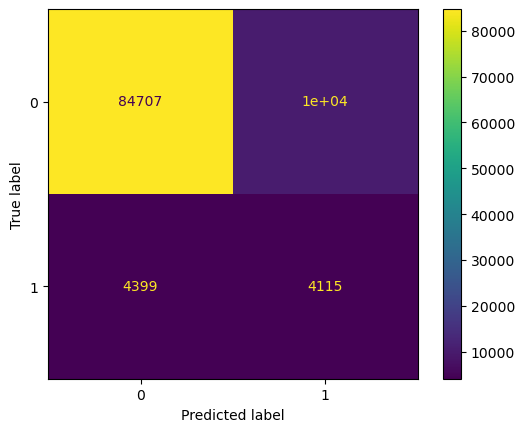

In [221]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')), #Imputing median for missing values
    ('mms', MinMaxScaler())
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#Estimator pipeline with our preprocessing in there
multi_nb_classifier = Pipeline([
    ('pre', preprocess),
    ('mnb', MultinomialNB(alpha = .0001))
])

#Fit model
multi_nb_classifier.fit(X_train_cleaned, y_train);

my_metrics(multi_nb_classifier, X_train_cleaned, X_test_cleaned)

That helped a ton with accuracy but hurt recall. Now we only detect half of the heart diseased patients. Not ideal.

# Fifth Model
**Strategy:**
- Let's get rid of the Min Max scaler as it hurt our recall and add some feature selection with TruncatedSVD

Train Accuracy: 0.9178404737473583
Test Recall: 0.0
Test Accuracy: 0.9178407380244722
Balanced Accuracy: 0.5
Recall: 0.0

Test Confusion Matrix:


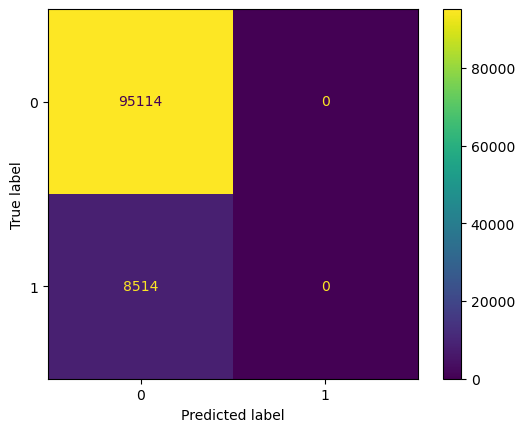

In [220]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')), #Imputing median for missing values
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#Estimator pipeline with our preprocessing in there
multi_nb_classifier = Pipeline([
    ('pre', preprocess),
    ('tSVD', TruncatedSVD(n_components=100)),
    ('mms', MinMaxScaler()),
    ('mnb', MultinomialNB(alpha = .0001))
])

#Fit model
multi_nb_classifier.fit(X_train_cleaned, y_train);

my_metrics(multi_nb_classifier, X_train_cleaned, X_test_cleaned)

This is just the base model, very bad.

# Sixth Model
**Strategy:**
- Use our thrid model with an oversampler to help with the imbalanced data

Train Accuracy: 0.3254021609415761
Test Recall: 0.829183305927492
Test Accuracy: 0.3255104797931061
Balanced Accuracy: 0.5555705024450242
Recall: 0.8308668076109936

Test Confusion Matrix:


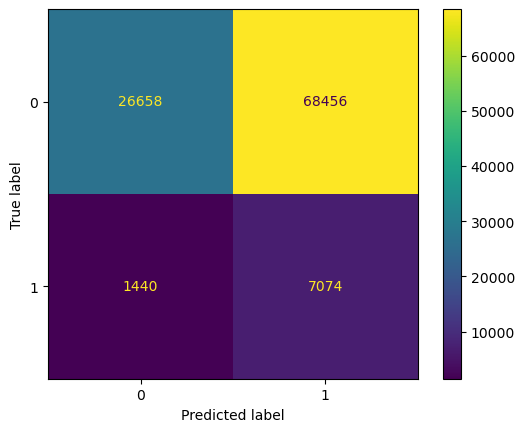

In [230]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')) #Imputing median for missing values
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#USing dufferent function for to make pipeline to accommodate for RandomOverSampler
multi_nb_classifier = make_pipeline(preprocess, RandomOverSampler(sampling_strategy = 1 ,random_state = 42), MultinomialNB(alpha = .00000001))

#Fit model
multi_nb_classifier.fit(X_train_cleaned, y_train);

my_metrics(multi_nb_classifier, X_train_cleaned, X_test_cleaned)

## With MinMax Scaler

Train Accuracy: 0.7585876358630096
Test Recall: 0.7329496515543027
Test Accuracy: 0.7568514301154128
Balanced Accuracy: 0.7476635235768585
Recall: 0.7366690157387832

Test Confusion Matrix:


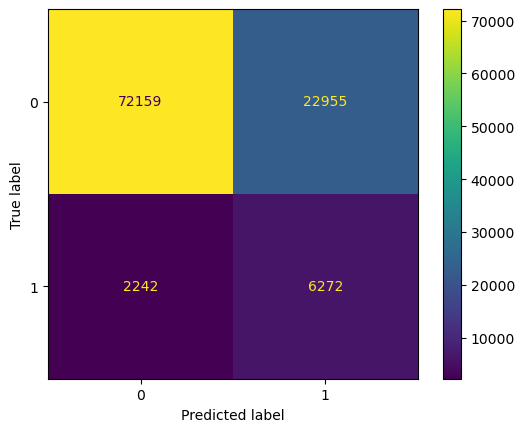

In [284]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')), #Imputing median for missing values
    ('mms', MinMaxScaler())
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#USing dufferent function for to make pipeline to accommodate for RandomOverSampler
multi_nb_classifier = make_pipeline(preprocess, RandomOverSampler(sampling_strategy = 1 ,random_state = 42), MultinomialNB(alpha = .00000001))

#Fit model
multi_nb_classifier.fit(X_train_cleaned, y_train);

my_metrics(multi_nb_classifier, X_train_cleaned, X_test_cleaned, y_train, y_test)

Barely the best Recall Score!

# Seventh model:
**Strategy:**
- Same as sixth but with different oversampler, now SMOTE

Train Accuracy: 0.32452401707394746
Test Recall: 0.8274998042439903
Test Accuracy: 0.32414984367159455
Balanced Accuracy: 0.5545084669214049
Recall: 0.8301620859760395

Test Confusion Matrix:


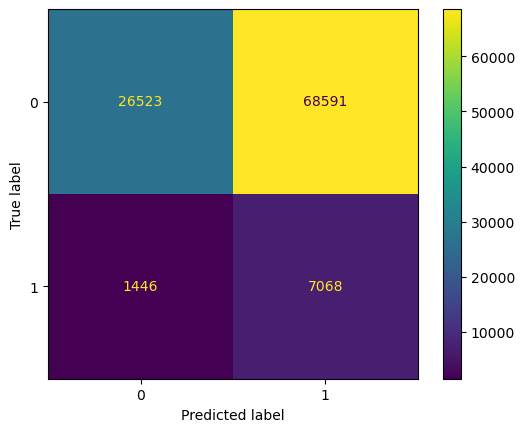

In [233]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')) #Imputing median for missing values
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#USing dufferent function for to make pipeline to accommodate for RandomOverSampler
multi_nb_classifier = make_pipeline(preprocess, SMOTE(random_state = 42), MultinomialNB(alpha = .00000001))

#Fit model
multi_nb_classifier.fit(X_train_cleaned, y_train);

my_metrics(multi_nb_classifier, X_train_cleaned, X_test_cleaned)

## With MinMaxScaler

Train Accuracy: 0.750513858911552
Test Recall: 0.7501761804087386
Test Accuracy: 0.7484560157486394
Balanced Accuracy: 0.7511105573451566
Recall: 0.7542870566126381

Test Confusion Matrix:


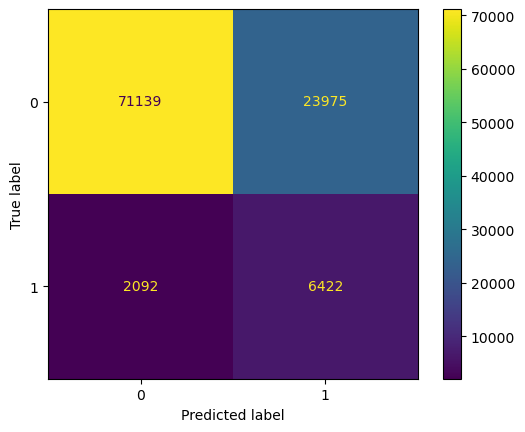

In [286]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')), #Imputing median for missing values
    ('mms', MinMaxScaler())
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#USing dufferent function for to make pipeline to accommodate for RandomOverSampler
multi_nb_classifier = make_pipeline(preprocess, SMOTE(random_state = 42), MultinomialNB(alpha = .00000001))

#Fit model
multi_nb_classifier.fit(X_train_cleaned, y_train);

my_metrics(multi_nb_classifier, X_train_cleaned, X_test_cleaned, y_train, y_test)

Barely Worse Recall than OVerSampling

# Eighth model:
**Strategy:**
- Same as sixth but with different oversampler, now with ADYSON

Train Accuracy: 0.3226294136379281
Test Recall: 0.8298097251585623
Test Accuracy: 0.32214266414482573
Balanced Accuracy: 0.5540032116745935
Recall: 0.8314540756401222

Test Confusion Matrix:


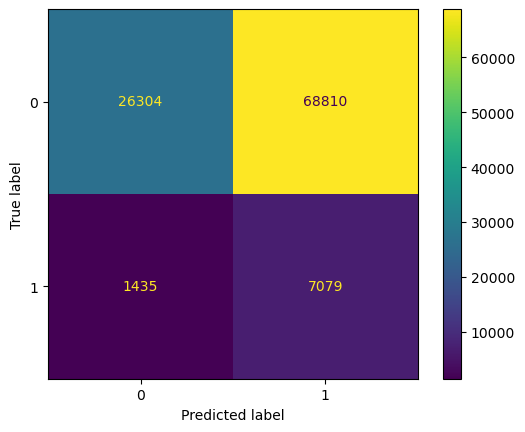

In [235]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')) #Imputing median for missing values
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#USing dufferent function for to make pipeline to accommodate for RandomOverSampler
multi_nb_classifier = make_pipeline(preprocess, ADASYN(random_state = 42), MultinomialNB(alpha = .00000001))

#Fit model
multi_nb_classifier.fit(X_train_cleaned, y_train);

my_metrics(multi_nb_classifier, X_train_cleaned, X_test_cleaned)

ADASYN had slightly better recall, bu barely and not worth the time it took to train.

# Two Step process

My thought here is that we could model the ones we predicted yes for to see if we could be more sure when we diagnose someone with our model. Right now, when we predict someone to have heart disease, we are only 10% certain that they have it. 5% of those we predict are healthy have heart disease. 

With our second model, hopefully we could have more accuarte results

In [271]:
#Only keep observations we predicted yes on for train set
X_train_cleaned['predictions'] = multi_nb_classifier.predict(X_train_cleaned)
y_train = pd.DataFrame(y_train)
y_train['predictions'] = multi_nb_classifier.predict(X_train_cleaned)

X_train_predicted = X_train_cleaned[X_train_cleaned['predictions'] == 1].drop(columns = 'predictions')
y_train_predicted = y_train[y_train['predictions'] == 1].drop(columns = 'predictions')['_michd']

#Only keep observations we predicted yes on for test set
X_test_cleaned['predictions'] = multi_nb_classifier.predict(X_test_cleaned)
y_test = pd.DataFrame(y_test)
y_test['predictions'] = multi_nb_classifier.predict(X_test_cleaned)

X_test_predicted = X_test_cleaned[X_test_cleaned['predictions'] == 1].drop(columns = 'predictions')
y_test_predicted = y_test[y_test['predictions'] == 1].drop(columns = 'predictions')['_michd']

In [272]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')) #Imputing median for missing values
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#Estimator pipeline with our preprocessing in there
multi_nb_classifier = Pipeline([
    ('pre', preprocess),
    ('mnb', MultinomialNB(alpha = .00000001))
])

#Fit model
multi_nb_classifier.fit(X_train_predicted, y_train_predicted);

Train Accuracy: 0.6883098610127907
Test Recall: 0.6275064873790989
Test Accuracy: 0.688716414763668
Balanced Accuracy: 0.6646108570744531
Recall: 0.6349766916231107

Test Confusion Matrix:


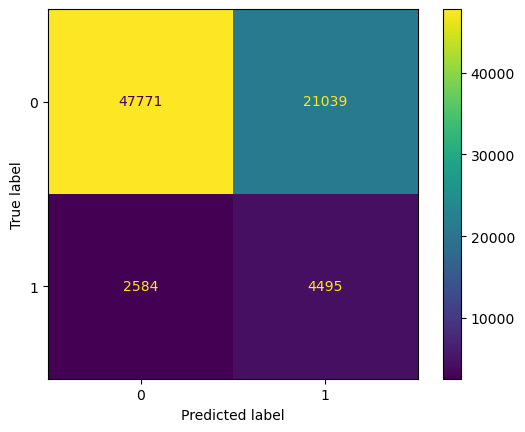

In [274]:
my_metrics(multi_nb_classifier, X_train_predicted, X_test_predicted, y_train_predicted, y_test_predicted)

This model was only trained and tested on observations that were predicted to have heart disease from our first model. 

17% of the predicted heart diseased people actually have it and 5 % of those we predicted don't have it actually have it.